In [1]:
import pandas as pd

# Load the data
data = data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/New folder/PYPL Historical Data.csv") 
data.head

<bound method NDFrame.head of            Date  Close   Open   High    Low    Vol. Change %
0     6/21/2024  60.61  59.92  60.74  59.67  18.87M    1.35%
1     6/20/2024  59.80  59.25  59.99  58.79  12.87M    1.15%
2     6/18/2024  59.12  59.92  60.10  59.04  13.42M   -1.68%
3     6/17/2024  60.13  60.37  60.64  59.48  13.56M   -0.83%
4     6/14/2024  60.63  61.29  61.64  60.31  10.37M   -1.47%
..          ...    ...    ...    ...    ...     ...      ...
374  12/22/2022  68.57  68.54  68.82  66.39  16.49M   -0.92%
375  12/21/2022  69.21  68.81  70.19  68.07  13.86M    0.65%
376  12/20/2022  68.76  68.39  70.13  68.13   9.47M   -0.28%
377  12/19/2022  68.95  69.06  69.60  67.75  15.33M   -0.45%
378  12/16/2022  69.26  69.40  70.86  68.45  25.74M   -0.73%

[379 rows x 7 columns]>

In [2]:
def calculate_rsi(data, window=21):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data['Close'])


In [3]:
data = data.dropna()  # Loại bỏ các hàng chứa giá trị NaN do tính RSI và MA

In [4]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size 
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

C:\Users\admin\AppData\Local\Temp\ipykernel_13520\1613652237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_13520\1613652237.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(how='any', axis=0, inplace=True)


In [5]:
from sklearn.preprocessing import MinMaxScaler
import warnings


pd.options.mode.chained_assignment = None 
# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close', 'Open', 'High', 'Low','RSI']
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (302, 5)
Validation data shape: (37, 5)
Test data shape: (39, 5)


In [85]:
# Training data
seq_len = 14
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, 0][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)


# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)


# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (288, 14, 5) (288,)
Validation set shape (23, 14, 5) (23,)
Testing set shape (25, 14, 5) (25,)


In [86]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dropout, Dense, GlobalAveragePooling1D, Conv1D, BatchNormalization
from tensorflow.keras.models import Model

class Time2Vector(tf.keras.layers.Layer):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(self.seq_len, 1),
                                              initializer='uniform',
                                              trainable=True)
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(self.seq_len, 1),
                                           initializer='uniform',
                                           trainable=True)
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(self.seq_len, 1),
                                                initializer='uniform',
                                                trainable=True)
        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(self.seq_len, 1),
                                             initializer='uniform',
                                             trainable=True)
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, x, training=False):
        x_time = tf.range(self.seq_len, dtype=tf.float32)
        x_time = tf.expand_dims(x_time, axis=0)
        x_time = tf.expand_dims(x_time, axis=-1)

        time_linear = self.weights_linear * x_time + self.bias_linear
        time_periodic = tf.math.sin(tf.multiply(x_time, self.weights_periodic) + self.bias_periodic)
        time_features = tf.concat([time_linear, time_periodic], axis=-1)
        time_features = tf.tile(time_features, [tf.shape(x)[0], 1, 1])
        time_features = self.dropout(time_features, training=training)

        return time_features

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_model():
    input_shape = (14, 5)
    seq_len = input_shape[0]
    embed_dim = 16
    num_heads = 4
    ff_dim = 64

    inputs = Input(shape=input_shape)
    time_embedding = Time2Vector(seq_len)(inputs)
    x = Concatenate(axis=-1)([inputs, time_embedding])

    # Add Convolutional Layer
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust embedding dimension before passing to TransformerEncoder
    x = Dense(embed_dim)(x)

    for _ in range(4):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.MeanAbsolutePercentageError())
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Example of model fitting with validation data
# model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=100, batch_size=32, callbacks=callbacks)


# Giải thích các cải tiến:
# Thêm lớp Convolutional Layer: Lớp Conv1D giúp mô hình học các đặc trưng không gian từ dữ liệu chuỗi thời gian, có thể giúp tăng cường khả năng học đặc trưng của mô hình.
# BatchNormalization sau Conv1D: Giúp mô hình ổn định hơn trong quá trình huấn luyện.
# Các cải tiến khác: Giữ các cải tiến trước như tăng số lượng heads, thêm các lớp TransformerEncoder, và sử dụng BatchNormalization và Dropout để giảm overfitting.


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 14, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vector_8      │ (None, 14, 2)     │         56 │ input_layer_40[0… │
│ (Time2Vector)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 14, 7)     │          0 │ input_layer_40[0… │
│ (Concatenate)       │                   │            │ time2_vector_8[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 14, 32)    │        704 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 32)    │        128 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 14, 16)    │        528 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 14, 16)    │      6,496 │ dense_88[0][0]    │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 14, 16)    │      6,496 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 14, 16)    │      6,496 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 14, 16)    │      6,496 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_133         │ (None, 16)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 128)       │      2,176 │ dropout_133[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_97[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_134         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 1)         │        129 │ dropout_134[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,217 (118.04 KB)

 Trainable params: 29,897 (116.79 KB)

 Non-trainable params: 320 (1.25 KB)

In [87]:
import time

start_time = time.time()
# Bước 7: Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 263ms/step - loss: 1434.7200 - val_loss: 262.2369
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1624.5575 - val_loss: 296.4724
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1463.2517 - val_loss: 315.9273
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1590.4547 - val_loss: 348.3934
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1687.0714 - val_loss: 378.5113
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1485.5365 - val_loss: 406.6058
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1285.9210 - val_loss: 449.7002
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1118.8141 - val_loss: 466.8253
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1705.9811 - val_loss: 478.2541
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1252.5511 - val_loss: 469.9588
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1480.8854 - val_loss: 448.3170
Epoch 12/100
8/8 

In [88]:
# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 4))), axis=1))[:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


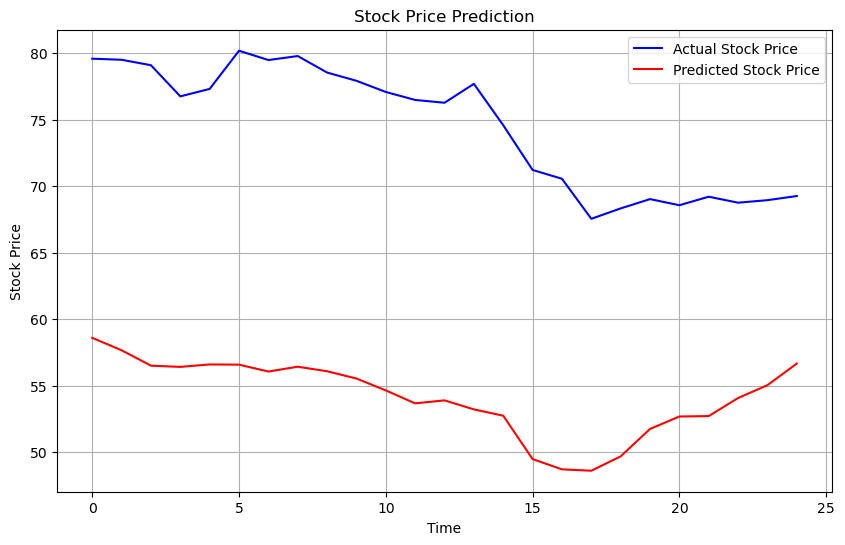

Root Mean Squared Error: 20.5559711316881
Mean Absolute Percentage Error: 0.2713894766117507
Thời gian training mô hình: 70.9679651260376


In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")

print('Thời gian training mô hình:',training_time)